In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.append('../helpers/')

import os
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve


from feature_selection import FeatureSelection

select_feature = FeatureSelection()


In [81]:
def compare_models(models, param_grids, X_train, y_train, X_val, y_val, scoring_metric='accuracy', cv=10):
    all_models = []
    
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=2, scoring=scoring_metric)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Store the best model and its parameters
        all_models.append({'model': best_model, 'params': best_params})
    
    # Evaluate the best models on a separate validation set
    models_report = []
    for model_info in all_models:
        model = model_info['model']
        y_pred = model.predict(X_val)

        # Accuracy score
        accuracy = accuracy_score(y_val, y_pred)
        
        # F1 score
        f1 = f1_score(y_val, y_pred)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_val, y_pred)
        true_positives = conf_matrix[1, 1]
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        false_negatives = conf_matrix[1, 0]

        # Sensitivity (True Positive Rate or Recall)
        sensitivity = true_positives / (true_positives + false_negatives)

        # Specificity (True Negative Rate)
        specificity = true_negatives / (true_negatives + false_positives)

        # Precision
        precision = true_positives / (true_positives + false_positives)

        models_report.append({
            'model': model, 
            'best_params': model_info['params'], 
            'accuracy': accuracy, 
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'precision': precision})
    
    # return best_model, best_score, best_params, all_models
    return models_report
    

In [4]:
ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

In [5]:
experiment              = 3

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None)
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None)

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None)
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None)

In [6]:
train_nevus_df.head()


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.003906,0.010586,3.627673,0.032592,5.590849,12.962111,0.003906,0.009306,3.054257,0.026076,...,0.017826,0.016285,0.018685,0.018685,0.020074,0.014141,0.007319,0.073348,0.347937,0.0
1,0.003906,0.006406,1.990036,0.014412,6.612989,2.789321,0.003906,0.006059,2.359529,0.013304,...,0.015360,0.012883,0.020381,0.017023,0.019762,0.011142,0.007871,0.084335,0.301383,0.0
2,0.003906,0.012463,4.485626,0.043669,5.261551,20.449217,0.003906,0.011281,3.832070,0.036486,...,0.015440,0.013021,0.018877,0.019531,0.023338,0.015481,0.008381,0.089910,0.400306,0.0
3,0.003906,0.009731,3.655664,0.028149,5.784594,13.168047,0.003906,0.007152,2.961299,0.017002,...,0.018000,0.016330,0.018767,0.017930,0.019574,0.013581,0.008611,0.073663,0.340263,0.0
4,0.003906,0.012468,4.113493,0.043701,5.079543,16.822559,0.003906,0.009250,3.045493,0.025811,...,0.013619,0.015311,0.017493,0.019781,0.023619,0.019993,0.012359,0.087644,0.432200,0.0


In [7]:
print(train_nevus_df.shape)

(7725, 105)


In [8]:
train_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.003906,0.004846,0.866540,0.009917,6.821035,-0.845557,0.003906,0.004115,0.569717,0.008242,...,0.007885,0.008702,0.010465,0.013727,0.020567,0.022927,0.016177,0.081679,0.478398,1.0
1,0.003906,0.009304,3.110399,0.026066,5.752192,8.962885,0.003906,0.006753,2.091162,0.015580,...,0.014958,0.015119,0.016079,0.017165,0.019433,0.016565,0.011448,0.065283,0.367760,1.0
2,0.003906,0.011715,3.305057,0.039042,4.986072,9.886728,0.003906,0.009415,2.738572,0.026600,...,0.005950,0.006917,0.008635,0.012485,0.021433,0.026533,0.019844,0.092346,0.538815,1.0
3,0.003906,0.007015,2.658633,0.016504,6.566395,6.551500,0.003906,0.005387,2.660783,0.011336,...,0.018185,0.011881,0.017308,0.009706,0.010900,0.004329,0.002658,0.122135,0.138162,1.0
4,0.003906,0.008983,3.295780,0.024566,6.029446,10.991496,0.003906,0.007163,2.242579,0.017041,...,0.014727,0.012560,0.016387,0.014988,0.017108,0.012425,0.007321,0.091177,0.312458,1.0


In [9]:
print(train_others_df.shape)

(7470, 105)


In [10]:
val_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.003906,0.008967,3.056522,0.024493,5.963221,8.973989,0.003906,0.009085,3.327701,0.025035,...,0.015652,0.014783,0.015896,0.017254,0.020160,0.016035,0.009071,0.069790,0.385342,0.0
1,0.003906,0.008102,2.151166,0.020711,5.857988,3.186463,0.003906,0.005606,1.715020,0.011951,...,0.014693,0.015052,0.017415,0.018481,0.021189,0.018237,0.010619,0.075759,0.398167,0.0
2,0.003906,0.006051,2.071912,0.013278,6.598399,3.991298,0.003906,0.004471,1.439740,0.009024,...,0.015067,0.013090,0.016567,0.016644,0.019877,0.014017,0.009719,0.074842,0.349240,0.0
3,0.003906,0.005929,3.324888,0.012905,6.953759,12.320268,0.003906,0.005621,2.646637,0.011996,...,0.014617,0.011673,0.019523,0.016050,0.019467,0.012125,0.007575,0.090821,0.337288,0.0
4,0.003906,0.007639,2.653999,0.018845,6.362201,5.720409,0.003906,0.007604,2.771503,0.018708,...,0.015430,0.016370,0.018485,0.020096,0.022307,0.018070,0.010526,0.079141,0.393970,0.0


In [11]:
print(val_nevus_df.shape)

(1931, 105)


In [12]:
val_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.003906,0.007101,2.898542,0.016816,6.486648,9.094543,0.003906,0.005382,3.192499,0.011320,...,0.009160,0.008281,0.009402,0.011321,0.014533,0.012165,0.006221,0.077381,0.331912,1.0
1,0.003906,0.007871,2.050016,0.019765,5.915789,2.870014,0.003906,0.006258,1.391339,0.013932,...,0.018393,0.016711,0.016604,0.015752,0.015133,0.010811,0.006707,0.049419,0.249822,1.0
2,0.003906,0.008371,2.861103,0.021845,6.242858,7.131025,0.003906,0.005859,2.735013,0.012693,...,0.016150,0.013227,0.019079,0.014310,0.015823,0.008842,0.005150,0.083383,0.233371,1.0
3,0.003906,0.007507,3.394838,0.018333,6.453406,15.632707,0.003906,0.006473,3.923633,0.014634,...,0.014479,0.012450,0.018763,0.015775,0.018396,0.012131,0.007452,0.094242,0.297619,1.0
4,0.003906,0.008143,2.462333,0.020880,6.143307,4.536312,0.003906,0.005200,1.311196,0.010829,...,0.014331,0.012035,0.014646,0.015773,0.018304,0.012823,0.006744,0.071442,0.349892,1.0


In [13]:
print(val_others_df.shape)

(1865, 105)


In [14]:
# Concatenate the 'nevus' and 'others' dataframes
train_features = pd.concat([train_nevus_df, train_others_df], ignore_index=True)
val_features = pd.concat([val_nevus_df, val_others_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)


In [15]:
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

X_val.head()


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
298,0.003906,0.007949,2.476268,0.020084,6.083987,5.244693,0.003906,0.006197,2.056992,0.013737,...,0.014026,0.016085,0.016507,0.017385,0.018948,0.020730,0.016674,0.009863,0.074107,0.383415
3078,0.003906,0.013654,4.537892,0.051631,4.893095,20.649601,0.003906,0.011992,4.030384,0.040723,...,0.012302,0.016102,0.014113,0.019015,0.019960,0.023742,0.015706,0.008215,0.085862,0.402779
1361,0.003906,0.010601,3.147719,0.032673,5.328911,8.852881,0.003906,0.011670,3.960868,0.038769,...,0.012119,0.014759,0.016548,0.018219,0.020744,0.022841,0.018789,0.011419,0.084244,0.417467
2711,0.003906,0.008222,2.345179,0.021213,5.828956,4.650671,0.003906,0.007078,2.026683,0.016731,...,0.016296,0.019978,0.018000,0.019419,0.019122,0.018741,0.011352,0.006978,0.068337,0.319848
2416,0.003906,0.007149,1.860630,0.016991,6.220841,2.048289,0.003906,0.007188,2.049136,0.017134,...,0.014196,0.016559,0.016563,0.017363,0.018485,0.019930,0.015433,0.008863,0.071107,0.369211


In [16]:
# X_train, selected_feature_indices  = select_feature.max_entropy_feature_selection(X_train, y_train)
# X_train

In [17]:
# X_val = X_val.iloc[:, selected_feature_indices]
# X_val

In [18]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [19]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [20]:
print(X_train_normalized.shape, y_train_encoded.shape, X_val_normalized.shape, y_val_encoded.shape)

(15195, 104) (15195,) (3796, 104) (3796,)


In [21]:
# Define the list of models and their respective hyperparameter grids
models = [
    # SVC(),
    LogisticRegression(), 
    # KNeighborsClassifier(),
    # RandomForestClassifier(),
    LinearDiscriminantAnalysis(),
    # XGBClassifier()
    ] 
        

param_grids = [
    # {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]},
    {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']},
    # {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
    # {'n_estimators' : [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    {'solver': ['svd', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},
    # {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0], 'gamma': [0, 1, 5]}
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy')

# Save the best model to a file
# best_model_filename = ROOT_PATH/'best_model.pkl'
# with open(best_model_filename, 'wb') as file:
#     pickle.dump(best_model, file)

print("Model Report:", models_report)
# print("Best Score:", best_score)
# print("Best Params:", best_params)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=n

In [99]:
models_report

[{'model': LinearDiscriminantAnalysis(),
  'best_params': {'shrinkage': None, 'solver': 'svd'},
  'accuracy': 0.7763435194942044,
  'f1': 0.771343926743873,
  'sensitivity': 0.767828418230563,
  'specificity': 0.7845675815639565,
  'precision': 0.7748917748917749},
 {'model': LogisticRegression(C=10, solver='newton-cholesky'),
  'best_params': {'C': 10, 'penalty': 'l2', 'solver': 'newton-cholesky'},
  'accuracy': 0.773709167544784,
  'f1': 0.7686506867761917,
  'sensitivity': 0.7651474530831099,
  'specificity': 0.7819782496116002,
  'precision': 0.7721861471861472}]

In [94]:
best_model = models_report[0]['model']
best_model

LinearDiscriminantAnalysis()

In [ ]:
# = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]}
#svc = SVC()

# Create a GridSearchCV object with a classifier and the parameter grid
#grid_search = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, verbose=10)

# Fit the grid search to your training data
#grid_search.fit(X_train_normalized, y_train_encoded)

# Get the best hyperparameters and the best model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

In [19]:
# best_params

In [95]:
y_pred = best_model.predict(X_val_normalized)
print(y_pred)

[0 0 0 ... 0 0 1]


### Model evaluation

In [96]:
fpr, tpr, _ = roc_curve(y_val_encoded, y_pred)
roc_auc = auc(fpr, tpr)

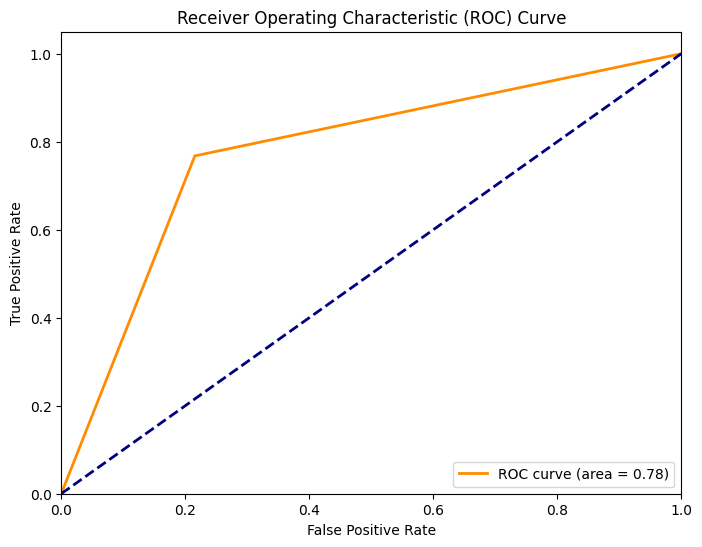

In [97]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7763435194942044


## Predicting in the test set

In [92]:
# best_model_filename = ROOT_PATH/'best_model.pkl'
# # Load the saved model from a file
# with open(best_model_filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# # Now you can use loaded_model to make predictions on new samples
# X_pred = loaded_model.predict(X_test)